# "Introduction to analysis of variance (ANOVA)"

> "ANOVA is one of the most fundamental techniques in data analysis. It allows us to tell whether there are statistically relevant differences between the means of several independent groups of data. Here we provide a conceptual introduction about the technique with code examples from scratch."

- toc: true
- branch: master
- badges: true
- comments: true
- author: Borja Requena
- categories: [Statistics, Data Analysis, ANOVA]
- image: images/anova.png

This post is part of a series in which we provide an introduction to statistics and data analysis introducing analysis of variance (ANOVA) and regression. They contain most of the teaching material developed for the [Msc of Multidisciplinary Research in Experimental Sciences (BIST)](https://mmres.bist.eu/). 

The main goal is to provide an intuition about the main ideas behind the different techniques together with simple code examples that implement them from scratch. 

In [ ]:
#hide
import numpy as np
from scipy.special import beta
import matplotlib.pyplot as plt
%matplotlib inline

## Introduction

In any field of study, data comes with all kinds of noise and variability. Hence, it is often difficult to compare the data extracted from different experiments straight away, unless there are major obvious differences between them. Let us, first, build some intuition with an example and, then, dive into the formalism.

For instance, we may want to compare the performance of different drugs to treat a certain disease. In this case, we would collect data from patients treated with each drug and we would obtain several groups of data, each with their corresponding variability. Patients treated with the same drug may undergo very different recovery processes which depend on several different factors, such as age, health condition, environmental conditions, etc. Therefore, in order to tell whether some drugs work better than others, we must be able to distinguish between the variance in the data due to the usage of different drugs and the variance due to all the other factors. 

Below we illustrate a couple of examples with synthetic data that show two cases in which we compare three populations with fixed means (black lines) and different variability. In the left one, the main contribution to the variability of the data is due to using different drugs, making it easy to compare them and study their effects. On the contrary, the right one shows a case in which the effect of the drugs is not so obvious. The means are still different, but the question is whether these differences remain significant, that is when they are larger than what we would expect by chance alone. Furthermore, as the variance in each population increases, the error in the estimated mean (red dashed line) increases.  

> Note: It is important to distinguish between the real mean $\mu$ (black line) and the sample estimate $\bar{y}$ (red line). The real mean is inaccessible for us and the best we can do is estimate it from our data. Usually, the more datapoints we gather, the better our estimate will become. 

In [ ]:
def synthetic_data(n, means, stds):
    "Create a synthetic dataset with `n` samples per mean and standard deviation."
    return [np.ones(n)*m + std*np.random.randn(n) for m, std in zip(means, stds)]

In [ ]:
np.random.seed(7) # Set random seed for reproducibility
n = 10
means = [0.5, 0.75, 0.65]
stds_easy, stds_hard = [0.01]*3, [0.15]*3
datasets = synthetic_data(n, means, stds_easy), synthetic_data(n, means, stds_hard)

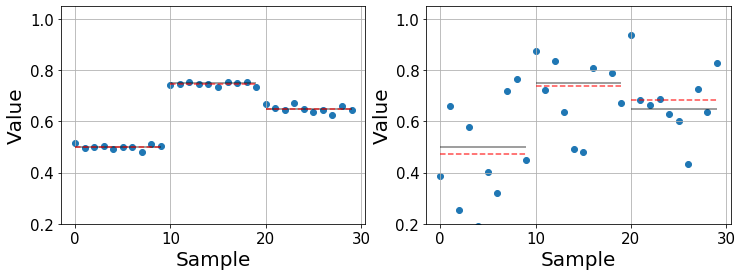

In [ ]:
#collapse-hide
x = np.arange(n*len(means))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, ds in zip(axes, datasets):
    ax.scatter(x, np.concatenate(ds, axis=0))
    for i in range(len(means)):
        ax.hlines(means[i], x[n*i], x[n*(i+1)-1], alpha=0.5)
        ax.hlines(np.mean(ds[i]), x[n*i], x[n*(i+1)-1], colors='r', linestyles='--', alpha=0.7)
    ax.grid()
    ax.tick_params(labelsize=15)
    ax.set_ylim(0.2, 1.05)
    ax.set_ylabel("Value", fontsize=20)
    ax.set_xlabel("Sample", fontsize=20);

Having seen the previous examples, let us formalize the analysis to see how we treat and quantify these situations.

## ANOVA

The main question we want to address with ANOVA is whether there are significant differences between the means of different groups of data. Formally, we confront the null hypothesis that all groups are equal $H_0:\mu_1=\mu_2=\dots=\mu_a$, where $a$ is the number of groups, with the hypothesis that, at least, two means are different $H_a: \mu_i\neq\mu_j$ for some $i,j\in [1, a]$.

However, we do not compare the means right away. Instead, we focus on the variability of the data. The idea is to separate the overall variability in two parts: the variation within the groups and the variation between them. Intuitively, we find significant differences whenever there is little variation within the groups and large variation between them, as in the previous left figure. 

### Variance

The variance measures the deviation of the data around its mean. Hence, we first need to estimate the mean $\bar{y}$ and then compute the deviations of each data point with respect to it $y_i-\bar{y}$. However, deviations take positive and negative values adding up to zero, by definition, so we need to consider their **sum of squares** (SS) instead as a measure of variability for the data $$SS= \sum_{i=1}^n (y_i-\bar{y})^2,$$
which ensures that all the terms in the sum are positive and contribute to the measure of the variation. 

However, SS is an extensive measure that increases with the number of samples, which would not allow us to compare the variability between groups of different sizes. Therefore, we need to normalize it, obtaining what's known as the **variance**. The sample variance $s^2$ is obtained normalizing the SS by its number of degrees of freedom (DF) such that $$s^2 = \frac{1}{n-1}\sum_{i=1}^n (y_i-\bar{y})^2.$$
In a distribution with $n$ samples, we only have $(n-1)$ DF provided that the deviations are subject to the constraint that they must add up to zero. Intuitively, if we had $n-1$ deviations, we could guess the value of the last one and so it is "not free". 

In ANOVA, the variance is often refered to as **mean square** (MS).

### Partitioning the variability

As previously introduced, we split the overall variability of the data into two components: the variability between and within the different groups. In order to asses whether there are significant differences between groups, we need to be able to compare these two variabilities. If the variability between groups is much larger than the one within groups, we can conclude that the groups are different. Conversely, if the variability within groups is much larger than the one between groups, we cannot tell the groups apart. More precisely, we compare their associated MS by computing the SS for each component and their DF, so let us introduce the following quantities:  
- $SS_{total} = \sum_{i, j}^{a, n_i}(y_{ij} - \bar{y})^2$ is the total SS of the samples with respect to the **grand mean** $\bar{y}$, which is the mean of all samples. It is, therefore, a measure of the total variability of the data.  
- $SS_{within} = \sum_{i, j}^{a, n_i} (y_{ij} - \bar{y_i})^2$ is the SS of the samples with respect to their group mean $\bar{y_i}$. This quantity is also known as the **error SS** and measures the variability of the data within the groups.
- $SS_{between} = \sum_{i}^a n_i(\bar{y_i} - \bar{y})^2$ is the SS of the group mean with respect to the grand mean. This quantity is also known as the **treatment SS** and measures the variability of the data between the groups. 

In the previous equations, the indexes $i,j$ respectively denote group $i\in[1,a]$ and sample within the group $j\in[1, n_i]$, where $n_i$ denotes the number of samples in group $i$. This way, we can write the total SS in terms of the other two $$SS_{total} = SS_{within} + SS_{between}$$

Similarly, we can define the MS associated to each SS by dividing with the proper degrees of freedom: 
- $DF_{total} = n-1$ is the total number of degrees of freedom.
- $DF_{within} = n-a$ is the number of degrees of freedom associated to the variation within groups. For each group we have $(n_i - 1)$ degrees of freedom. 
- $DF_{between} = a-1$ is the number of degrees of freedom associated to the variation between groups. For $a$ groups, we can infer the last deviation from the previous $a-1$.

Analogously to the SS, DF fulfill the relationship $DF_{total} = DF_{within} + DF_{between}$. 

With these quantities we can define the MS corresponding to the variation within groups $MS_{within} = SS_{within}/DF_{within}$ and between groups $MS_{between} = SS_{between}/DF_{between}$.

### F-ratio

With the partition of variability that we have introduced, we can compute the **F-ratio** $$F=\frac{MS_{between}}{MS_{within}},$$ which quantifies the relationship between the amount of variation in both regimes. $F\gg 1$ indicates that there may be large differences between groups and $F\leq 1$ suggests that there are no differences between them.

Nevertheless, since we are dealing with sample estimates, $F$ is a random variable that can take a wide range of values. This phenomenon is described by the **F-distribution**, which represents the likelihood to obtain the values of $F$ under the null hypothesis given $DF_{within}, DF_{between}$. With this, we only accept that there are significant differences between groups if $F$ is sufficiently large to be achieved by chance with a probability lower than $0.05$. This is known as an **F-test**.

Below, we provide a couple of examples of F-distribution given $(2, 27)$ and $(9, 40)$ DF denoting (between, within). The first example is equivalent to having 3 groups with 10 samples each and the second is equivalent to 10 groups with 50 samples each. This distribution has a closed form as shown [here](https://en.wikipedia.org/wiki/F-distribution#Definition). 

In [ ]:
def f_distribution(x, d_b, d_w):
    "F-distribution given `d_b` between DF and `d_w` within DF."
    def pdf(x):
        return (d_b/d_w)**(d_b/2)*x**(d_b/2-1)*(1+x*d_b/d_w)**(-(d_b+d_w)/2)/beta(d_b/2, d_w/2)
    norm = pdf(np.linspace(0, 100, 1000)).sum()
    return pdf(x)/norm

In [ ]:
x = np.linspace(0, 7, 100)
fs = f_distribution(x, 2, 27), f_distribution(x, 9, 40)

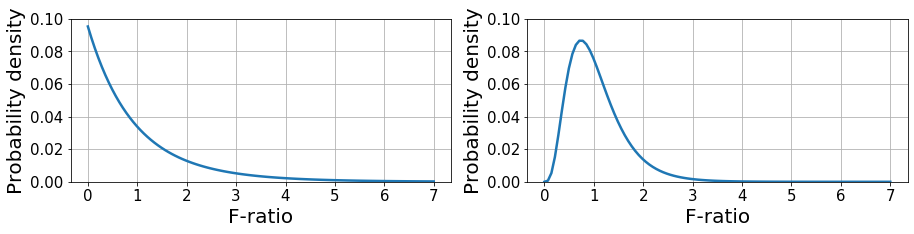

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

for ax, f in zip(axes, fs):
    ax.plot(x, f, linewidth=2.5)
    ax.grid()
    ax.tick_params(labelsize=15)
    ax.set_ylim(0, 0.1)
    ax.set_ylabel("Probability density", fontsize=20)
    ax.set_xlabel("F-ratio", fontsize=20);

## Example: fertilizers

Let's illustrate the concepts that we have introduced above with an example. We consider a field study in which three fertilizers are tested and we want to compare their efficiency. Each fertilizer is used to grow ten plots and, then, the crops are harvested. 

We will use the data in Table 1.1 from {% cite GrafenBook2002%}, where they provide the yield of each plot in tonnes. 

In [ ]:
yield_1 = np.array([6.27, 5.36, 6.39, 4.85, 5.99, 7.14, 5.08, 4.07, 4.35, 4.95])
yield_2 = np.array([3.07, 3.29, 4.04, 4.19, 3.41, 3.75, 4.87, 3.94, 6.28, 3.15])
yield_3 = np.array([4.04, 3.79, 4.56, 4.55, 4.53, 3.53, 3.71, 7.00, 4.61, 4.55])
yields = np.stack([yield_1, yield_2, yield_3], axis=0)

Let's start by visualizing the data and see whether we can clearly identify differences between each group.

In [ ]:
n, (a, n_i) = yields.size, yields.shape
print(f"There are {a} groups with {n_i} samples each for a total of {n} samples.")
grand_mean, group_means = yields.mean(), yields.mean(1)

There are 3 groups with 10 samples each for a total of 30 samples.


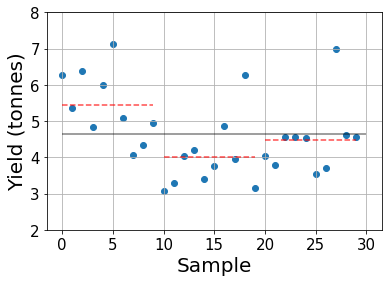

In [ ]:
#collapse-hide
x = np.arange(n)
plt.plot(figsize=(6, 4))
plt.scatter(x, yields.ravel())
plt.hlines(grand_mean, 0, n, alpha=0.5)
for i, m in enumerate(group_means):
    plt.hlines(m, x[n_i*i], x[n_i*(i+1)-1], colors='r', linestyles='--', alpha=0.7) 
plt.grid()
plt.ylim(2, 8)
plt.tick_params(labelsize=15)
plt.ylabel("Yield (tonnes)", fontsize=20)
plt.xlabel("Sample", fontsize=20);

The gray line indicates the grand mean and the red dashed lines show the sample group means.

While it looks like the first fertilizer provides the highest yield, on average, we cannot draw clear conclusions as many plots treated with fertilizer 1 yield less crops than some treated with other fertilizers. Furthermore, with such a small amount of samples we could have had good or bad "luck" in some cases so we need a more elaborate analysis to determine whether the observed differences in means are statistically relevant or not.  

Let's implement what we've learned! 

In [ ]:
ss_within = np.sum((yields - group_means[:, None])**2)
ss_between = np.sum(n_i*(group_means - grand_mean)**2)
df_within, df_between = n - a, a - 1
ms_within, ms_between = ss_within/df_within, ss_between/df_between
f_ratio = ms_between/ms_within
print(f"F-ratio of {f_ratio:.4f}.")

F-ratio of 5.7024.


We have found a rather large F-ratio, suggesting that there may be significant differences between fertilizers. However, we have to check the p-value of this F-ratio for the given degrees of freedom. 

To construct the p-value, we have to check what is the probability that the F-ratio is equal or larger to the obtained value under the null hypothesis. For this, we have to integrate the probability distribution from the given value to $+\infty$, which we will approximate by a fixed value of 100, given that the probability distribution peaks arround 1. Notice that this senario of 3 groups with 10 samples corresponds to the left figure of the F-distribution above.  

Here, we will perform a very basic numerical integration in which we approximate the area under the curve by trapezoids.

In [ ]:
fs = np.linspace(f_ratio, 100, 1000)
prob = f_distribution(fs, df_between, df_within)
p_value = np.trapz(prob)
print(f"p-value {p_value:.4f}")

p-value 0.0087


The obtained p-value is significantly lower than the typical $0.05$ threshold, so we can accept the hypothesis that there are significant differences between fertilizers. 

## References
{% bibliography --cited %}